In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 39.61 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


## Get Data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
from torch.utils.data import DataLoader

# set the batch size
BATCH_SIZE = 32

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f468cb69110>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

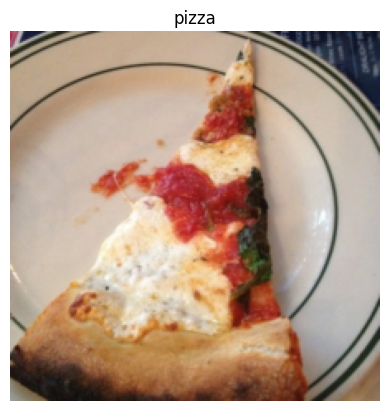

In [ ]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis('off');

## **ViT architecture with PyTorch transformer layers**
1. PatchEmbedding (turn images into embedding patches)
2. Transformer Encoder layer (comprised of alternating MSA and MLP blocks)
3. Stack multiple transformer encoder layers on top of each other.
4. MLP head
5. Put it all together to create ViT.

In [ ]:
# Demonstration using a random tensor
import torch
random_image_tensor = torch.randn(1, 3, 224, 224)
random_image_tensor.shape

torch.Size([1, 3, 224, 224])

### 1. PatchEmbedding()

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim, # 768
                                 kernel_size=patch_size, # 16
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [ ]:
# Demo
patch_embedding = PatchEmbedding()
patch_embedding_output = patch_embedding(random_image_tensor)
patch_embedding_output.shape

torch.Size([1, 196, 768])

### 2. TransformerEncoderLayer()

In [ ]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12, # MSA Heads
                                                       dim_feedforward=3072, # MLP size
                                                       dropout=0.1,
                                                       activation='gelu',
                                                       batch_first=True,
                                                       norm_first=True)

In [ ]:
summary(model=transformer_encoder_layer,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoderLayer                  [1, 196, 768]             --
├─LayerNorm: 1-1                         [1, 196, 768]             1,536
├─MultiheadAttention: 1-2                [1, 196, 768]             2,362,368
├─Dropout: 1-3                           [1, 196, 768]             --
├─LayerNorm: 1-4                         [1, 196, 768]             1,536
├─Linear: 1-5                            [1, 196, 3072]            2,362,368
├─Dropout: 1-6                           [1, 196, 3072]            --
├─Linear: 1-7                            [1, 196, 768]             2,360,064
├─Dropout: 1-8                           [1, 196, 768]             --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.73
Input size (MB): 0.60
Forward/backward pass size (MB): 8.43
Params size (MB): 18.90
Estimated Total Size (MB): 27.93

### 3. Stacking Transformer Encoder Layers on top of each other

In [ ]:
transformer_encoder = nn.TransformerEncoder(
    encoder_layer=transformer_encoder_layer,
    num_layers=12
)
# transformer_encoder

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
summary(model=transformer_encoder,
        input_size=patch_embedding_output.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [1, 196, 768]             --
├─ModuleList: 1-1                        --                        --
│    └─TransformerEncoderLayer: 2-1      [1, 196, 768]             --
│    │    └─LayerNorm: 3-1               [1, 196, 768]             1,536
│    │    └─MultiheadAttention: 3-2      [1, 196, 768]             2,362,368
│    │    └─Dropout: 3-3                 [1, 196, 768]             --
│    │    └─LayerNorm: 3-4               [1, 196, 768]             1,536
│    │    └─Linear: 3-5                  [1, 196, 3072]            2,362,368
│    │    └─Dropout: 3-6                 [1, 196, 3072]            --
│    │    └─Linear: 3-7                  [1, 196, 768]             2,360,064
│    │    └─Dropout: 3-8                 [1, 196, 768]             --
│    └─TransformerEncoderLayer: 2-2      [1, 196, 768]             --
│    │    └─LayerNorm: 3-9               [1, 196, 768]    

## 5. Putting it all together to create ViT
Skipping step 4 to combine it in step 5.

A class token is a special token added to the input data in transformer-based models, primarily for classification tasks. It's used in models like ***`Vision Transformers (ViTs)`*** and ***`BERT`*** to help the model summarize important information about the input.

***Why is a Class Token Used?***
- Acts as a global representation for the entire input sequence.
- Helps the model focus on the most relevant features during training.
- Ensures a consistent structure in the input, even when sequences vary in length.

***Why is Layer Normalization Used?***

Stabilizes Training
- Prevents activations from becoming too large or too small.
- Reduces sensitivity to parameter initialization.

Speeds Up Convergence
- Allows models to learn faster by reducing internal covariate shifts.
- Helps avoid vanishing and exploding gradients.

Improves Generalization
- Makes models more robust by standardizing activations at each layer.
- Prevents overfitting in complex architectures.


In [ ]:
class ViT(nn.Module):
  def __init__(self,
               img_size=224, # Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # Table 1
               dropout=0.1,
               mlp_size=3072, # Table 1
               num_transformer_layers=12, # Table 1
               num_heads=12, # Table 1 (number of multi-heads self-attention heads)
               num_classes=1000): # generic number of classes (can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisible by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_classes,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size*img_size)//patch_size**2 # [N = HW/P^2]
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding
    self.embedding_dropout = nn.Dropout(p=dropout)

    # 5. Create stack transformer encoder layer (single)
    # self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
    #                                                             nhead=num_heads,
    #                                                             dim_feedforward=mlp_size,
    #                                                             dropout=dropout,
    #                                                             activation='gelu',
    #                                                             batch_first=True,
    #                                                             norm_first=True)
    # 6. Create stack transformer encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              dropout=dropout,
                                                                                              activation='gelu',
                                                                                              batch_first=True,
                                                                                              norm_first=True), # create a single transformer
                                                     num_layers=num_transformer_layers) # stack it N times

    # 7. Create MLP head (like a classifier head)
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # '-1' means infer the dimensions

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1) # this only concatenates the 2nd dimension, viz, dim 1
    # print(x.shape)

    # Add the positional embedding to patch embedding
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through transformer encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

In [ ]:
demo_image = torch.randn(1, 3, 224, 224)
print(demo_image.shape)

# ViT
vit = ViT(num_classes=len(class_names))
vit(demo_image)

torch.Size([1, 3, 224, 224])


tensor([[-0.6249,  0.1057, -0.0800]], grad_fn=<AddmmBackward0>)

In [ ]:
import torch
from torch import nn
embedding_dim = 768
patch_size = 16
img_size = 224
num_patches = (img_size*img_size)//patch_size**2
pos_embedding = nn.Parameter(torch.randn(1,num_patches+1, embedding_dim))
pos_embedding.shape

torch.Size([1, 197, 768])

In [ ]:
summary(model=vit,
        input_size=demo_image.shape)

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

## Creating a python script using the ViT model (`vit.py`)

In [ ]:
%%writefile vit.py

import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim, # 768
                                 kernel_size=patch_size, # 16
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


class ViT(nn.Module):
  def __init__(self,
               img_size=224, # Table 3
               num_channels=3,
               patch_size=16,
               embedding_dim=768, # Table 1
               dropout=0.1,
               mlp_size=3072, # Table 1
               num_transformer_layers=12, # Table 1
               num_heads=12, # Table 1 (number of multi-heads self-attention heads)
               num_classes=1000): # generic number of classes (can be adjusted)
    super().__init__()

    # Assert image size is divisible by patch size
    assert img_size % patch_size == 0, "Image size must be divisible by patch size."

    # 1. Create patch embedding
    self.patch_embedding = PatchEmbedding(in_channels=num_classes,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 2. Create class token
    self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                    requires_grad=True)

    # 3. Create positional embedding
    num_patches = (img_size*img_size)//patch_size**2 # [N = HW/P^2]
    self.positional_embedding = nn.Parameter(torch.randn(1, num_patches+1, embedding_dim))

    # 4. Create patch + position embedding
    self.embedding_dropout = nn.Dropout(p=dropout)

    # 5. Create stack transformer encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                                              nhead=num_heads,
                                                                                              dim_feedforward=mlp_size,
                                                                                              dropout=dropout,
                                                                                              activation='gelu',
                                                                                              batch_first=True,
                                                                                              norm_first=True), # create a single transformer
                                                     num_layers=num_transformer_layers) # stack it N times

    # 6. Create MLP head (like a classifier head)
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  def forward(self, x):
    # Get some dimensions from x
    batch_size = x.shape[0]

    # Create the patch embedding
    x = self.patch_embedding(x)
    # print(x.shape)

    # First expand the class token across the batch size
    class_token = self.class_token.expand(batch_size, -1, -1) # '-1' means infer the dimensions

    # Prepend the class token to the patch embedding
    x = torch.cat((class_token, x), dim=1) # this only concatenates the 2nd dimension, viz, dim 1
    # print(x.shape)

    # Add the positional embedding to patch embedding
    x = self.positional_embedding + x
    # print(x.shape)

    # Dropout on patch + positional embedding
    x = self.embedding_dropout(x)

    # Pass embedding through transformer encoder stack
    x = self.transformer_encoder(x)

    # Pass 0th index of x through MLP head
    x = self.mlp_head(x[:, 0])

    return x

Writing vit.py


In [ ]:
from vit import ViT
imported_vit = ViT(num_classes=len(class_names))
summary(model=imported_vit,
        input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ViT                                           [1, 3]                    152,064
├─PatchEmbedding: 1-1                         [1, 196, 768]             --
│    └─Conv2d: 2-1                            [1, 768, 14, 14]          590,592
│    └─Flatten: 2-2                           [1, 768, 196]             --
├─Dropout: 1-2                                [1, 197, 768]             --
├─TransformerEncoder: 1-3                     [1, 197, 768]             --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-2      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-3      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-4      [1, 197, 768]             7,087,872
│    │    └─TransformerEncoderLayer: 3-5      [1, 197, 76

### Using the pretrained ViT model and weights

In [ ]:
# Create ViT feature extractor model
import torchvision

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # 'DEFAULT' means best available weoght
# vit_weights.transforms()
pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights)
# pretrained_vit

# Freeze all layers in pretrained ViT model
for param in pretrained_vit.parameters():
  param.requires_grad = False

# Update the pretrained ViT model
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Get summary
summary(model=pretrained_vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 85.3MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [ ]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train directory
train_dir_20_percent = data_20_percent_path / "train"

# Preprocess the data
vit_transform = vit_weights.transforms()
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir, # use the 10% data for testing
                                                                                          transform=vit_transform,
                                                                                          batch_size=1024) # can adjust to maybe 32?


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
len(train_dataloader), len(train_dataloader_20_percent), len(test_dataloader)

(8, 1, 1)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Train a pretrained ViT feature extractor
# from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2156 | train_acc: 0.2333 | test_loss: 1.0258 | test_acc: 0.4933
Epoch: 2 | train_loss: 0.9635 | train_acc: 0.5222 | test_loss: 0.8168 | test_acc: 0.6267
Epoch: 3 | train_loss: 0.7688 | train_acc: 0.7267 | test_loss: 0.6602 | test_acc: 0.7067
Epoch: 4 | train_loss: 0.6219 | train_acc: 0.8178 | test_loss: 0.5427 | test_acc: 0.8000
Epoch: 5 | train_loss: 0.5116 | train_acc: 0.8711 | test_loss: 0.4539 | test_acc: 0.8800
Epoch: 6 | train_loss: 0.4290 | train_acc: 0.8889 | test_loss: 0.3868 | test_acc: 0.8933
Epoch: 7 | train_loss: 0.3669 | train_acc: 0.9089 | test_loss: 0.3359 | test_acc: 0.9067
Epoch: 8 | train_loss: 0.3201 | train_acc: 0.9133 | test_loss: 0.2973 | test_acc: 0.9067
Epoch: 9 | train_loss: 0.2843 | train_acc: 0.9178 | test_loss: 0.2679 | test_acc: 0.9200
Epoch: 10 | train_loss: 0.2566 | train_acc: 0.9244 | test_loss: 0.2454 | test_acc: 0.9333


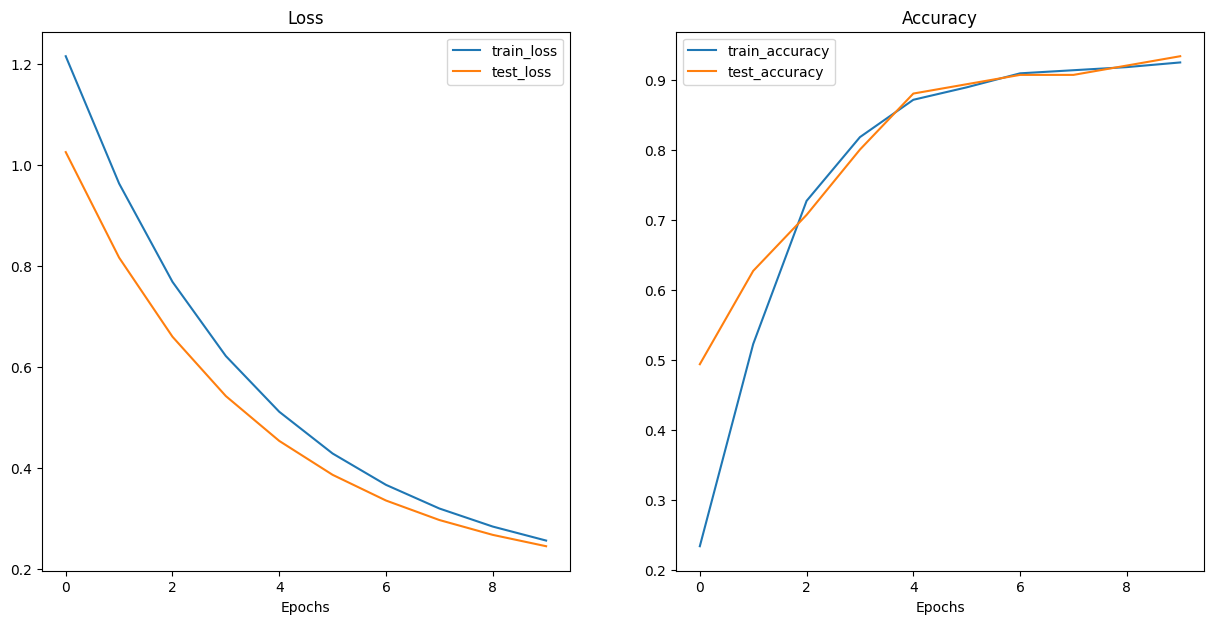

In [ ]:
# Examine results
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

## Re-buiding the ViT model using "***`ViT_B_Weights.IMAGENET1K_SWAG_E2E_V1`***" weights

In [ ]:
import torchvision

# Download pretrained ViT weights and model
vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 # get SWAG weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=vit_weights_swag)
# pretrained_vit

# Freeze all layers in pretrained ViT model
for param in pretrained_vit_swag.parameters():
  param.requires_grad = False

# Update the pretrained ViT model
embedding_dim = 768 # ViT_Base
set_seeds()
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=embedding_dim),
    nn.Linear(in_features=embedding_dim,
              out_features=len(class_names))
)

# Get summary
summary(model=pretrained_vit_swag,
        input_size=(1, 3, 384, 384), # image heigh and width (384, 384)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:05<00:00, 59.5MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 384, 384]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 384, 384]     [1, 768, 24, 24]     (590,592)            False
├─Encoder (encoder)                                          [1, 577, 768]        [1, 577, 768]        443,136              False
│    └─Dropout (dropout)                                     [1, 577, 768]        [1, 577, 768]        --                   --
│    └─Sequential (layers)                                   [1, 577, 768]        [1, 577, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 577, 768]        [1, 577, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 577, 768]        [1, 5

In [ ]:
vit_transforms_swag = vit_weights_swag.transforms()
vit_transforms_swag

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Get 20% of the data
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

# Setup train directory
train_dir_20_percent = data_20_percent_path / "train"

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                               test_dir=test_dir,
                                                                                               transform=vit_transforms_swag,
                                                                                               batch_size=1024) # can adjust to maybe 32?


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [ ]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [ ]:
# Train a pretrained ViT feature extractor with SWAG weights
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=0.001)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_swag_results = engine.train(model=pretrained_vit_swag,
                                      train_dataloader=train_dataloader_20_percent,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0201 | train_acc: 0.5022 | test_loss: 0.7611 | test_acc: 0.7867
Epoch: 2 | train_loss: 0.7643 | train_acc: 0.8156 | test_loss: 0.5627 | test_acc: 0.8933
Epoch: 3 | train_loss: 0.5686 | train_acc: 0.9022 | test_loss: 0.4185 | test_acc: 0.9600
Epoch: 4 | train_loss: 0.4263 | train_acc: 0.9578 | test_loss: 0.3159 | test_acc: 0.9733
Epoch: 5 | train_loss: 0.3247 | train_acc: 0.9711 | test_loss: 0.2436 | test_acc: 0.9733
Epoch: 6 | train_loss: 0.2525 | train_acc: 0.9800 | test_loss: 0.1928 | test_acc: 0.9867
Epoch: 7 | train_loss: 0.2011 | train_acc: 0.9822 | test_loss: 0.1569 | test_acc: 0.9867
Epoch: 8 | train_loss: 0.1643 | train_acc: 0.9822 | test_loss: 0.1313 | test_acc: 0.9867
Epoch: 9 | train_loss: 0.1376 | train_acc: 0.9822 | test_loss: 0.1128 | test_acc: 0.9867
Epoch: 10 | train_loss: 0.1179 | train_acc: 0.9822 | test_loss: 0.0992 | test_acc: 0.9867


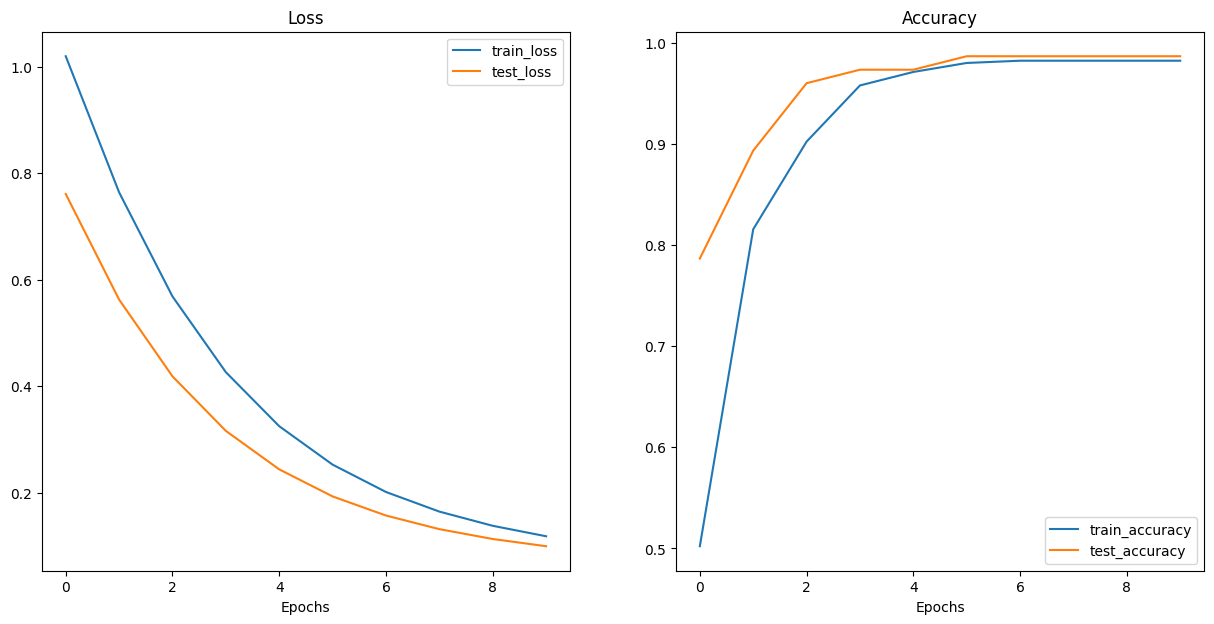

In [ ]:
# Plot the results
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_swag_results)

### Getting the most wrong of the predictions

In [ ]:
from tqdm.auto import tqdm
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label
def pred_and_stores(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create an empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict['image_path'] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict['class_name'] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path)
    transformed_image = transform(img).unsqueeze(0)
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict['pred_prob'] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict['pred_class'] = pred_class

    # Does the pred match the true label?
    pred_dict['correct'] = class_name == pred_class
    # print(pred_dict)

    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dict = pred_and_stores(test_paths=test_data_paths,
                                model=pretrained_vit_swag,
                                transform=vit_transforms_swag,
                                class_names=class_names,
                                device=device)
test_pred_dict[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.5375198125839233,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9863712191581726,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9731205701828003,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9727989435195923,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.9768378734588623,
  'pred_class': 'sushi',
  'correct': True}]

In [ ]:
# Turn the test_preds_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dict)
# sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=['correct','pred_prob'], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
51  data/pizza_steak_sushi/test/pizza/2508636.jpg      pizza   0.587981   
73  data/pizza_steak_sushi/test/pizza/1687143.jpg      pizza   0.994338   
71  data/pizza_steak_sushi/test/pizza/3475871.jpg      pizza   0.994295   
54  data/pizza_steak_sushi/test/pizza/2111981.jpg      pizza   0.993817   
53   data/pizza_steak_sushi/test/pizza/714866.jpg      pizza   0.993736   

   pred_class  correct  
51      steak    False  
73      pizza     True  
71      pizza     True  
54      pizza     True  
53      pizza     True

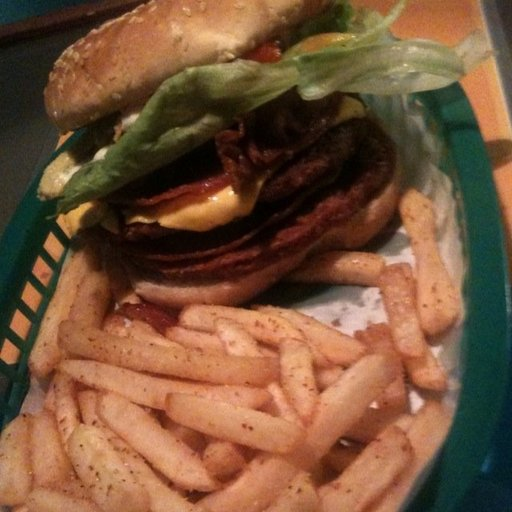

In [ ]:
from PIL import Image
image_check = Image.open('data/pizza_steak_sushi/test/pizza/2508636.jpg')
image_check

In [ ]:
test_pred_df.correct.value_counts()

correct
True     74
False     1
Name: count, dtype: int64

<ipython-input-37-cc84cfa36ccf>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
<ipython-input-37-cc84cfa36ccf>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
<ipython-input-37-cc84cfa36ccf>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
<ipython-input-37-cc84cfa36ccf>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, in

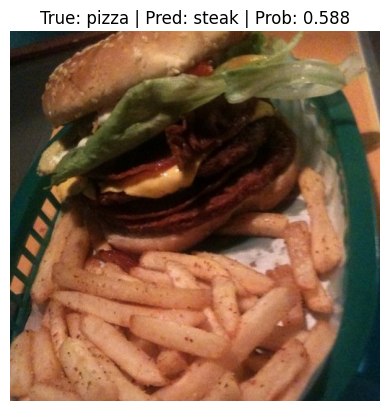

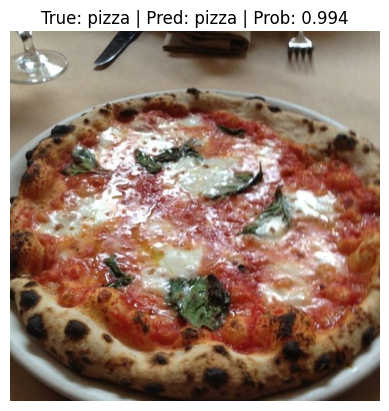

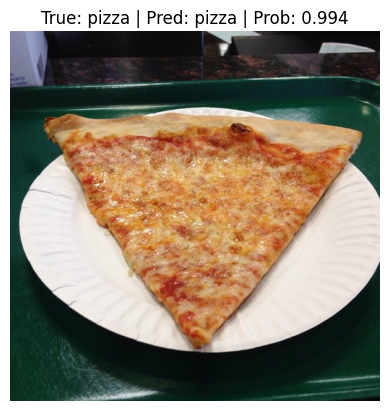

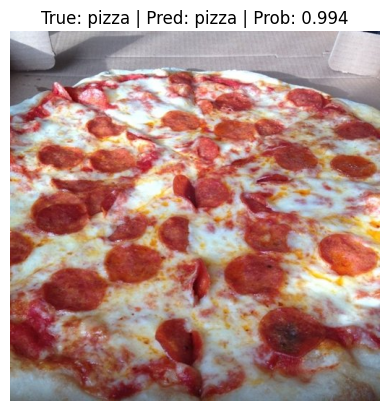

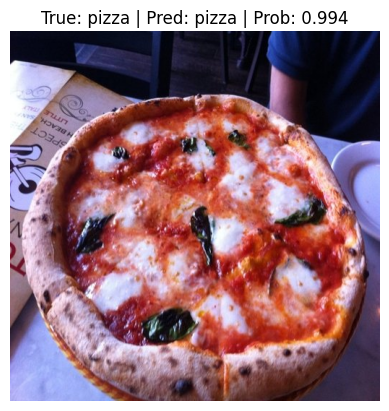

In [ ]:
import torchvision
import matplotlib.pyplot as plt
# Plot top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get the image as a tensor
  plt.figure()
  plt.imshow(img.permute(1,2,0)) #(H,W,C)
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis("off");

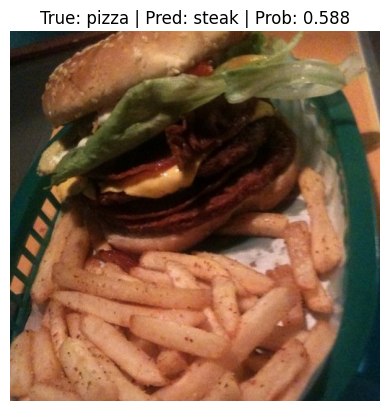

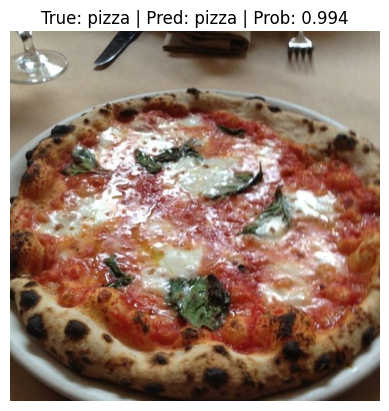

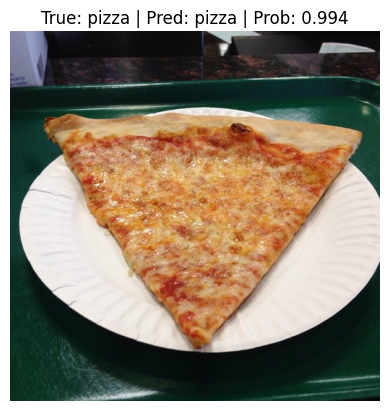

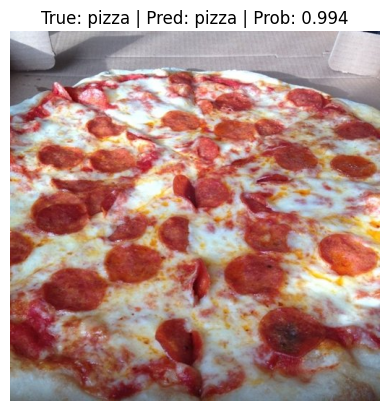

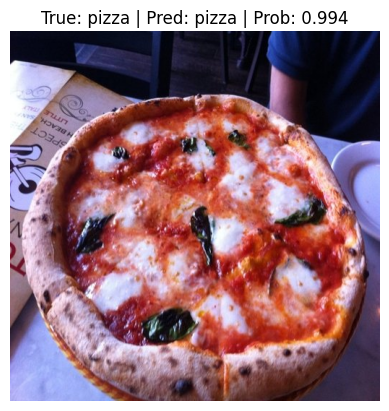

In [ ]:
for idx, row in top_5_most_wrong.iterrows():
    image_path = row['image_path']
    true_label = row['class_name']
    pred_prob = row['pred_prob']
    pred_class = row['pred_class']

    img = torchvision.io.read_image(str(image_path)) # get the image as a tensor
    plt.figure()
    plt.imshow(img.permute(1,2,0)) #(H,W,C)
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis("off");

### Making predictions on custom image


data/pizza_steak_sushi/test/pizza/04-pizza-dad.jpeg already exists, skipping download.


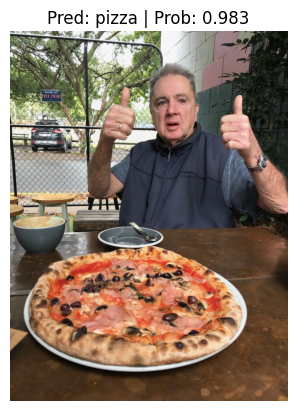

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path.parent / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit_swag,
                    image_path=custom_image_path,
                    image_size=(384, 384),
                    class_names=class_names)

In [ ]:
# import requests

# from going_modular.going_modular.predictions import pred_and_plot_image

# custom_image_path = image_path.parent / "steak-image.jpg"

# if not custom_image_path.is_file():
#   with open(custom_image_path, 'wb') as f:
#     # The original url redirects to a url that returns html content instead of image
#     # This link is directing to a HTML page, and that's what is being saved
#     # Changing the url to point to actual image file with correct extension
#     request = requests.get("https://download.freepik.com/free-photo/steak-served-with-french-fries-tomatoes_140725-3181.jpg", allow_redirects=True)
#     print(f"Downloading {custom_image_path}...")
#     f.write(request.content)
# else:
#   print(f"{custom_image_path} already exists, skipping download...")

# pred_and_plot_image(model=pretrained_vit_swag,
#                     image_path=custom_image_path,
#                     image_size=(384, 384),
#                     class_names=class_names)

data/pizza_steak_sushi/test/pizza/00-steak-image.jpg already exists, skipping download...


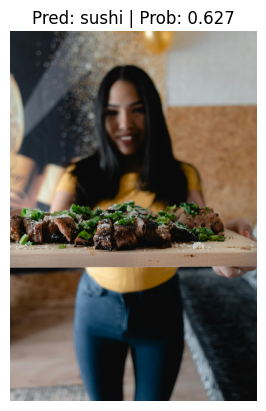

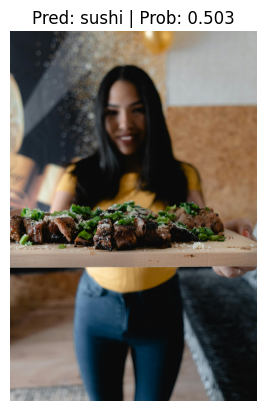

In [ ]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = image_path.parent / "00-steak-image.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://images.pexels.com/photos/2281204/pexels-photo-2281204.jpeg?cs=srgb&dl=pexels-gantas-2281204.jpg&fm=jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

pred_and_plot_image(model=pretrained_vit_swag,
                    image_path=custom_image_path,
                    image_size=(384, 384),
                    class_names=class_names)

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

It is steak!!